In [299]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Algorithms
from sklearn.svm import SVC

# Internal
from autocat.data.datasets import get_training_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel, Model
from autocat.models.evaluation import evaluate, plot_learning_curve

In [255]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

## Pipeline

In [256]:
# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [257]:
# Create a pipeline to transform the modelling data
pipeline = Pipeline([
    ('feaure_transactions_per_day', CombinedFeatureAdder(feature_transactions_per_day)),
    ('std_scaler', StandardScaler()),
    ('data_frame', PandasDataFrameTransformer(list(X.columns) + ['TransactionsPerDay']))
])

In [302]:
print('Training instances:', len(X))

Training instances: 6304


## Model

In [272]:
# Create the parameter grid
param_grid = [
    {
        'svm__gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100], 
        'svm__C': [.01, .1, 1., 10, 50, 100, 110, 125],
    }
]

In [274]:
# Train a model using grid search
scorer = make_scorer(f1_score, average='micro')
svm_model = GridSearchModel('svm', SVC(), param_grid, pipeline)
svm_model.train(X, y, 10, scorer)

In [275]:
svm_model.model

SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Evaluation

In [323]:
X_transformed = model.pipeline.fit_transform(X)
model_predictions = model.model.predict(X_transformed)

#### Training Set

In [324]:
# Evaluate the model on the training set
scorer = lambda y_true, y_pred: f1_score(y, model_predictions, average='micro')
svm_results = evaluate(model, pipeline.fit_transform(X), y, scorer)
print(classification_report(svm_results.labels, svm_results.predictions))

                      precision    recall  f1-score   support

           Body Care       0.76      0.79      0.78      1050
              Frozen       0.94      0.09      0.17       346
                Meat       1.00      0.82      0.90       114
    Packaged Grocery       0.74      0.95      0.83      3380
        Packaged Tea       1.00      0.05      0.10       250
Refrigerated Grocery       0.78      0.49      0.60       669
            Vitamins       0.69      0.39      0.50       495

         avg / total       0.77      0.75      0.71      6304



#### Cross Validation

In [305]:
CV=10

In [304]:
cv_predictions = cross_val_predict(svm_model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6930520304568528
                      precision    recall  f1-score   support

           Body Care       0.69      0.73      0.71      1050
              Frozen       0.28      0.03      0.06       346
                Meat       0.75      0.57      0.65       114
    Packaged Grocery       0.71      0.92      0.80      3380
        Packaged Tea       0.67      0.02      0.03       250
Refrigerated Grocery       0.70      0.42      0.53       669
            Vitamins       0.49      0.26      0.34       495

         avg / total       0.66      0.69      0.65      6304



The SVM model performs well for:
* Body Care
* Meat
* Packaged Grocery


The KNN model performs  slightly better overall but the SVM performs better (w.r.t. precision) on Refigerated Grocery and Packaged Tea.

#### Confusion Matrix

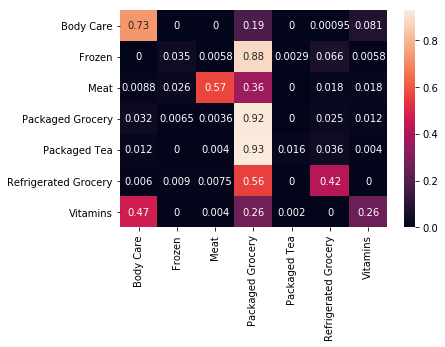

In [308]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [322]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

1.5714285714285714

This confusion matrix has more zero-valued entries per category than the KNN model indicating that the SVM model is doing a better job at reducing false negatives.

#### Learning Curve

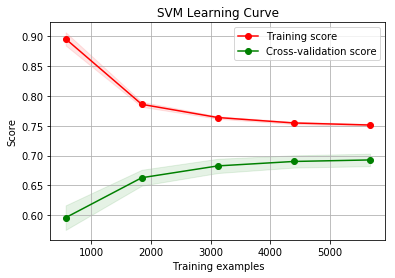

In [307]:
# Plot the learning curve
plot_learning_curve(svm_model.get_model_pipeline(), 'SVM Learning Curve', X, y, cv=CV);

The model appears to be suffering from both low bias and high variance - even with a training score of 72%, there are too many mis-classifications for this model to be useful.